In [1]:
import pandas as pd
import numpy as np
import os
import glob
from tensorflow import keras
from tensorflow.keras import layers

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [6]:
df = pd.read_csv('C://Users//nkdge//Desktop//eeg_train.csv')
df

,AF3,F7,F3,FC5,T7,P7,O1,02,P8,T8,FC6,F4,F8,AF4,label
0,4299.49,3997.44,4277.95,4116.92,4353.85,4623.08,4100.00,4623.59,4202.56,4229.23,4211.79,4278.97,4600.00,4369.23,1
1,4302.05,3985.64,4261.03,4129.74,4334.36,4615.38,4072.31,4585.64,4192.31,4225.13,4195.90,4283.08,4607.18,4358.46,0
2,4321.03,4015.90,4265.13,4122.56,4333.33,4613.33,4072.82,4602.05,4192.31,4223.08,4155.38,4286.15,4608.21,4371.79,0
3,4408.21,4104.10,4380.00,4232.31,4449.74,4750.26,4169.23,4731.28,4311.28,4352.31,4319.49,4388.21,4715.90,4464.10,0
4,4347.18,3975.38,4266.67,4102.56,4333.33,4617.95,4097.44,4612.82,4210.77,4240.51,4248.21,4313.33,4664.10,4411.79,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,4211.79,4015.90,4230.26,4107.69,4336.41,4623.08,4071.79,4605.64,4187.69,4225.13,4168.72,4240.51,4544.62,4265.13,1
1996,4268.72,4035.38,4237.95,4112.82,4346.15,4618.97,4066.15,4603.08,4192.82,4214.36,4189.74,4250.77,4586.67,4321.54,0
1997,4287.69,4007.69,4267.18,4128.21,4339.49,4611.28,4036.92,4603.59,4181.54,4228.21,4192.82,4260.51,4597.44,4353.33,0
1998,4297.95,4031.79,4275.90,4147.69,4365.64,4632.82,4093.33,4666.15,4211.79,4228.21,4210.77,4279.49,4604.10,4340.51,0


In [30]:
input_shape = [14]
model = keras.Sequential([layers.BatchNormalization(input_shape = input_shape),
                          layers.Dense(256, activation = 'relu'),
                          layers.BatchNormalization(),
                          layers.Dropout(0.7),
                          layers.Dense(256, activation = 'relu'),
                          layers.BatchNormalization(),
                          #layers.Dropout(0.5),
                          layers.Dense(256, activation = 'relu'),
                          layers.BatchNormalization(),
                          #layers.Dropout(0.5),
                          layers.Dense(256, activation = 'relu'),
                          layers.BatchNormalization(),
                          #layers.Dropout(0.5),
                          layers.Dense(1, activation = 'sigmoid')
                         ])

opt = keras.optimizers.Adam()
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

In [31]:
from sklearn.model_selection import train_test_split
x = df.drop(['label'], axis = 'columns')
y = df.label
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size = .8)

In [32]:
xvalid = xtest[0:200]
yvalid = ytest[0:200]

Best Validation Loss: 0.1679
Best Validation Accuracy: 0.9500
Best Loss: 0.0130
Best Accuracy: 0.9994


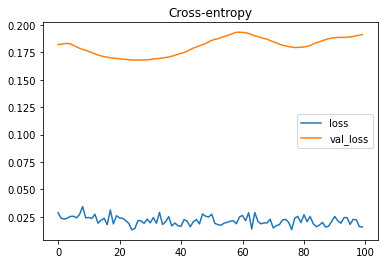

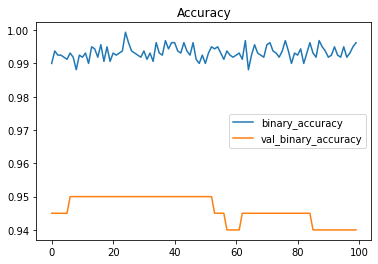

In [37]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    xtrain, ytrain,
    validation_data=(xvalid, yvalid),
    batch_size=2048,
    epochs=100,
    #callbacks=[early_stopping],
    verbose = 0
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")
print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(),
              history_df['val_binary_accuracy'].max()))
print(("Best Loss: {:0.4f}" +\
      "\nBest Accuracy: {:0.4f}")\
      .format(history_df['loss'].min(),
              history_df['binary_accuracy'].max()))


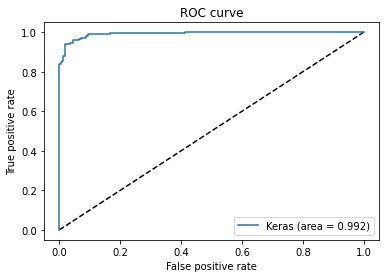

In [38]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(xtest).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(ytest, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()